In [1]:
import json

with open("summaries.json", "r") as json_file:
    summaries = json.load(json_file)

print("Loaded Summaries:", summaries)

Loaded Summaries: {'text_summaries': 'computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful insight learn computer vision high demand job market essential career ai machine learn datum science across industry like healthcare automotive robotic revolutionize industry power advancement self drive car medical diagnostic agriculture manufacturing automate visual task solve real world problem enhance public safety improve medical imaging optimize industrial process application computer vision computer vision tutorial design beginner experience professional cover key concept computer vision include image processing feature extraction object detection recognition image segmentation diving computer vision recommend foundational understanding machine learn deep learn opencv resource help build necessary background understanding implement computer vision

In [5]:
# Combine all summaries into a single string
content = summaries['text_summaries'] + " " + " ".join(summaries['table_summaries'] + summaries['image_summaries'])
print(content)

computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful insight learn computer vision high demand job market essential career ai machine learn datum science across industry like healthcare automotive robotic revolutionize industry power advancement self drive car medical diagnostic agriculture manufacturing automate visual task solve real world problem enhance public safety improve medical imaging optimize industrial process application computer vision computer vision tutorial design beginner experience professional cover key concept computer vision include image processing feature extraction object detection recognition image segmentation diving computer vision recommend foundational understanding machine learn deep learn opencv resource help build necessary background understanding implement computer vision technique effectively mathematical pr

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=250,
    length_function=len,
    add_start_index=True,
)

In [7]:
context_split = text_splitter.create_documents([content])
print("Number of chunks created:", len(context_split))
print("First chunk:", context_split[0].page_content)
print("First chunk metadata:", context_split[0].metadata)
chunks = text_splitter.split_text(content)
print(chunks[:5])

Number of chunks created: 46
First chunk: computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful insight learn computer vision high demand job market essential career ai machine learn datum science across industry like healthcare automotive robotic revolutionize industry power advancement self drive car medical diagnostic agriculture manufacturing automate visual task solve real world problem
First chunk metadata: {'start_index': 0}
['computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful insight learn computer vision high demand job market essential career ai machine learn datum science across industry like healthcare automotive robotic revolutionize industry power advancement self drive car medical diag

In [8]:
from torch import cuda
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

embed_model = HuggingFaceEmbeddings(
    model_name=embed_model_id,
    model_kwargs={'device': device},
    encode_kwargs={'device': device, 'batch_size': 32},
)

/tmp/ipykernel_71865/3863062560.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(
2025-04-07 18:48:12.521140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744051692.731151   71865 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744051692.791945   71865 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has a

In [10]:
embeddings = embed_model.embed_documents(chunks)

print(f"We have {len(embeddings)} doc embeddings, each with "
      f"a dimensionality of {len(embeddings[0])}.")
embeddings[:5]

We have 46 doc embeddings, each with a dimensionality of 384.


[[0.005046195816248655,
  -0.0545063242316246,
  -0.0064675952307879925,
  -0.07950173318386078,
  0.00237402250058949,
  -0.03304516524076462,
  0.033755190670490265,
  0.04041369631886482,
  -0.059008076786994934,
  -0.016589559614658356,
  -0.04671306908130646,
  -0.04502495750784874,
  0.012729167006909847,
  0.05362026020884514,
  -0.006099979393184185,
  0.006120246835052967,
  -0.0010323396418243647,
  0.020263249054551125,
  -0.08582062274217606,
  -0.07690884172916412,
  0.055688172578811646,
  -0.04779915511608124,
  -0.01962568424642086,
  -0.04974881932139397,
  -0.08476542681455612,
  0.09689443558454514,
  0.04834573343396187,
  -0.054050348699092865,
  0.019583653658628464,
  -0.05417044833302498,
  -0.01161167398095131,
  0.03180674463510513,
  0.08175301551818848,
  0.03659767657518387,
  -0.028535427525639534,
  0.026471326127648354,
  -0.03867191821336746,
  0.040330808609724045,
  0.06148958206176758,
  -0.04898862540721893,
  -0.05688435956835747,
  -0.045392420142

In [14]:
import os
from pinecone import Pinecone
os.environ['PINECONE_API_KEY'] = "pcsk_64Fbg1_27xutLJrXgzi9RaHXLxmvDLLXW8o4hQCpz4wgNkL7m3fFoLXqRZ1fXbCjP2nowZ"
pc = Pinecone(api_key=os.environ['PINECONE_API_KEY'])

In [15]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [17]:
index_name = 'webowl'
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=len(embeddings[0]),
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)


# Connect to the index
index = pc.Index(index_name)
print(f"Connected to index: {index_name}")

Connected to index: webowl


In [18]:
metadata = [{"chunk_id": i, "text": chunk} for i, chunk in enumerate(chunks)]
# Prepare data for upsert
pinecone_data = [
    {
        "id": f"chunk-{i}",     # Unique ID for the chunk
        "values": embeddings[i],  # Embedding vector
        "metadata": metadata[i]   # Metadata dictionary
    }
    for i in range(len(chunks))
]
pinecone_data[1]

{'id': 'chunk-1',
 'values': [0.0064069731160998344,
  -0.03614303097128868,
  0.011982964351773262,
  -0.06034281849861145,
  0.025321587920188904,
  -0.04271024838089943,
  0.0467291921377182,
  0.05438078194856644,
  -0.11650359630584717,
  0.006449948530644178,
  -0.06685621291399002,
  -0.02527141198515892,
  0.042072877287864685,
  0.027303434908390045,
  0.007803953252732754,
  0.0008269866812042892,
  -0.020952614024281502,
  0.021343572065234184,
  -0.05887145176529884,
  -0.07062463462352753,
  0.0034413167741149664,
  -0.012176614254713058,
  -0.009509757161140442,
  -0.04936341196298599,
  -0.07210995256900787,
  0.08683858811855316,
  0.06453883647918701,
  -0.040080297738313675,
  0.0038986869622021914,
  -0.04158148169517517,
  -0.0302263330668211,
  0.0401352196931839,
  0.049516696482896805,
  0.046308182179927826,
  0.03296004608273506,
  -0.001449599047191441,
  -0.030429644510149956,
  0.07731503993272781,
  0.057586029171943665,
  -0.06449273973703384,
  -0.0479073

In [31]:
index.upsert(vectors=pinecone_data)

print("Data upserted successfully!",index.describe_index_stats())

Data upserted successfully! {'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 46}},
 'total_vector_count': 46,
 'vector_type': 'dense'}


In [35]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Index  # Import the Index class directly

# Make sure 'index' is properly initialized as a pinecone.Index object
# You should have something like this earlier in your code:
# import pinecone
# pinecone.init(api_key="YOUR_API_KEY", environment="YOUR_ENVIRONMENT")
# index = pinecone.Index("your-index-name")

text_field = 'text'  # Field in metadata that contains text content

vectorstore = PineconeVectorStore(
    index=index,  # This should be a pinecone.Index instance
    embedding=embed_model,  # Your embedding function
    text_key=text_field
)

In [36]:
query = 'application of computer vision'

vectorstore.similarity_search(
    query,  # the search query
    k=3  # returns top 3 most relevant chunks of text
)

[Document(id='chunk-21', metadata={'chunk_id': 21.0}, page_content='device application computer vision healthcare computer vision use medical imaging detect disease abnormality help analyze x ray mris scan provide accurate diagnosis automotive industry self drive car computer vision use object detection lane keep traffic sign recognition help make autonomous drive safe efficient retail computer vision use retail inventory management theft prevention customer behaviour analysis track product shelf monitor customer movement agriculture agriculture computer vision'),
 Document(id='chunk-19', metadata={'chunk_id': 19.0}, page_content='detection system like yolo look facial recognition technology use various application like unlock smartphone surveillance integration computer vision augment reality ar virtual reality vr system use computer vision medical imaging disease diagnosis predict advancement real time object detection image recognition sophisticated use computer vision autonomous ve

In [38]:
from langchain_community.llms.ollama import Ollama
llm = Ollama(model="mistral:latest", temperature=0.7)

In [40]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

# Assume `vectorstore` and `llm` are already initialized.

# Create a retriever
retriever = vectorstore.as_retriever()

# Define a custom prompt for the QA process
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
**You are WebOwl**, a RAG-powered AI assistant trained to synthesize answers from a vector database of web-sourced knowledge.  
**For summary requests** (e.g., "summarize", "key points", "overview"):  
1. **Analyze all retrieved context** holistically.  
2. **Combine key ideas** into a cohesive narrative.  
3. **Prioritize breadth** over depth (cover all major themes).  
4. **Structure output** with headings/bullets for clarity.  

**For non-summary questions**: Answer directly with relevant excerpts.  

---  
**Retrieved Context** (from vectorstore):  
{context}  

**User Question**:  
{question}  

**WebOwl's Synthesis**:  
"""
)

# Create a RetrievalQA chain directly with the retriever and prompt
WebOwl = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",  
    chain_type_kwargs={"prompt": prompt_template}
)




In [41]:
# Run a query
query = "What are the applications of computer vision?"
result = WebOwl.run(query)
print(result)

/tmp/ipykernel_71865/704827047.py:3: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = WebOwl.run(query)


 **Applications of Computer Vision**

1. Object Detection: Computer vision is widely used for object detection in various domains. This includes recognizing and locating objects within images or videos, which is crucial for applications like autonomous vehicles for navigation purposes.

2. Deep Learning: Deep learning algorithms play a significant role in computer vision. They help in image classification tasks where the computer needs to identify specific objects.

3. Facial Recognition Technology: This technology uses computer vision for various applications such as unlocking smartphones, surveillance, and more. It's also integrated into augmented reality (AR) systems for facial filters, for example.

4. Augmented Reality/Virtual Reality Systems: Computer vision is essential for AR and VR systems. It helps these systems understand the visual input they receive from the real world.

5. Medical Imaging: In the medical field, computer vision is used for disease diagnosis by analyzing im

In [42]:
query = "Give a concise summary of of computer vision."
result = WebOwl.run(query)
print(result)

 **Computer Vision Overview:**

   - Computer Vision is a branch of Artificial Intelligence that helps computers understand and analyze visual data, such as images or videos, similar to how the human eye works.
   - Key concepts include object detection, which involves identifying and locating objects within an image or video, and image segmentation, where the boundaries of objects are defined at the pixel level.
   - Deep Learning plays a crucial role in computer vision tasks, with algorithms trained to perform object recognition and categorization based on properties like shape or texture.
   - Prerequisite skills for working in this field include understanding linear algebra, probability statistics, signal processing, and image processing techniques such as image transformation, enhancement, and noise reduction.
   - The ultimate goal is to enable machines to analyze different patterns within visual data points, with the ability to relate labels and examples to help improve their pe

In [44]:
query = "Type of Object Detection Approaches"
result = WebOwl.run(query)
print(result)

 **Object Detection Approaches**

   - **Single Stage Object Detection**: This approach directly predicts bounding boxes and class probabilities for each object category in a single pass through the image. Examples include YOLO (You Only Look Once) and SSD (Single Shot MultiBox Detector).

   - **Two Stage Object Detection**: This method involves two separate stages: first, proposing regions of interest that may contain objects, and then classifying those regions and refining their bounding boxes. Examples include Faster R-CNN (Region Convolutional Network) and Mask R-CNN.

   - **Image Segmentation**: While not strictly an object detection approach, image segmentation can be used for object detection purposes by partitioning the image into distinct regions and identifying objects based on pixel-level analysis. This method is particularly useful when dealing with scenes containing multiple overlapping objects.

   Both single stage and two stage object detection approaches are commonly

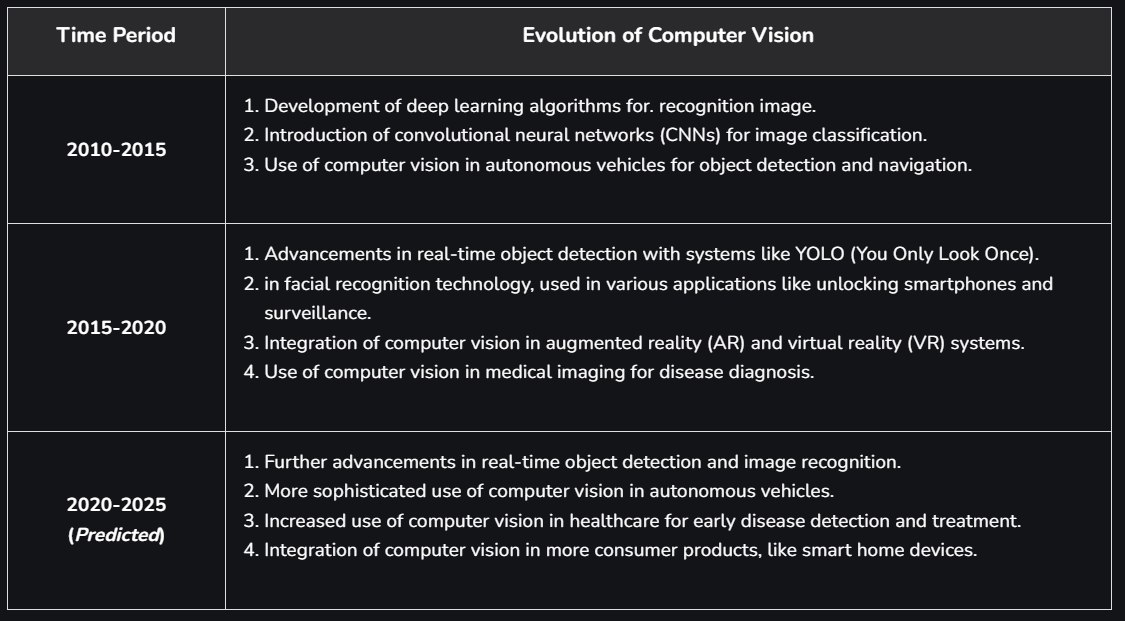

In [45]:
query = "Evolution of Computer Vision"
result = WebOwl.run(query)
print(result)

 **Evolution of Computer Vision**

   - **Early Beginnings**: Computer vision initially focused on enabling computers to interpret, extract information, and derive meaningful insights from digital images and videos, mimicking human perception. This was achieved through the development of algorithms and models that processed visual data.
   - **Development of Libraries**: Open source computer vision libraries like OpenCV were developed to facilitate machine learning tasks in this domain. Originally developed by Intel, OpenCV is a popular library used for computer vision tasks and is short for "Open Source Computer Vision Library".
   - **Deep Learning Revolution**: Object detection, an important concept in the computer vision domain, involves identifying and locating objects within images or videos. With the advent of deep learning, object detection techniques have significantly improved, helping computers better understand visual data. Deep learning tutorials provide insights into thes